In [12]:
import pandas as pd
import geopandas as gpd
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
import contextily as ctx

from tqdm import tqdm
tqdm.pandas()

from shapely.geometry import Polygon

import logging
logging.getLogger().setLevel(logging.INFO)
from dotenv import load_dotenv
load_dotenv()

sys.path.append(os.path.realpath('../'))
from util.isochrones import Isochrones
from util.extract_urbancenter import ExtractCenters

DROOT = '../1-data/'

cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.latest.xlsx'))
cities.head(3)

,city_name,country_id,city_id,priority
0,Trnava,SVK,3101,11
1,Amsterdam,NLD,2167,0
2,Arnhem,NLD,2226,0


In [13]:
CACHE = os.path.join(DROOT, '3-traveltime-cache', 'cache.michal.db')
isochrone_client   = Isochrones(db=CACHE)
urbancenter_client = ExtractCenters(src_dir=os.path.join(DROOT, '2-external'), 
                                    target_dir=os.path.join(DROOT, '2-popmasks'), res=100)

In [16]:
city = cities[cities.city_name == 'Trnava'].iloc[0]

# Extract urban center and read in as pickle
pcl_path = urbancenter_client.extract_city(city.city_name, city.city_id)
gdf = gpd.GeoDataFrame(pd.read_pickle(pcl_path))
gdf = gdf.rename(columns={'geometry': 'raster'}).set_geometry('raster')

# Check if records are all done    
peak_dt = datetime(2023, 8, 22, 8, 30, 0)
off_dt  = datetime(2023, 8, 22, 13, 30, 0)
isochrone_config = [
    ('transit_off',        [15, 30], off_dt,  'g'),
    ('transit_peak',       [15, 30], peak_dt, 'g'),
    ('transit_bike_off',   [15, 30], off_dt,  'g'),
    ('transit_bike_peak',  [15, 30], peak_dt, 'g'),
    ('driving_off',        [10, 25], off_dt,  'g'),
    ('driving_peak',       [10, 25], peak_dt, 'g'),
    ('cycling',            [15, 30], peak_dt, 'g'), 
    ('walking',            [15, 30], peak_dt, 'g')
]

# Retrieve all isochrones based on above configuration
isochrones, (_, _, frac_done) = isochrone_client.get_isochrones(
    city_id=city.city_id, 
    points=gdf.centroid.to_crs("EPSG:4326"),
    config=isochrone_config,
    dry_run=True,
    dry_run_geometry=True,
)

# Merge raster information
gdf = gdf.to_crs('EPSG:4326')
isochrones = isochrones.merge(gdf, left_on='pid', right_index=True)
isochrones['isochrone_buf'] = isochrones.isochrone.to_crs(isochrones.isochrone.estimate_utm_crs()).buffer(300).to_crs(isochrones.isochrone.crs)
isochrones.isochrone = isochrones.isochrone.fillna(Polygon())

# Calculating properties of habitants
logging.info("Starting calculation...")
isochrones['reach_km2'] = isochrones.isochrone.to_crs(isochrones.isochrone.estimate_utm_crs()).area
isochrones['reach_pop'] = isochrones.isochrone_buf.progress_apply(lambda x: gdf[gdf.intersects(x)].cell_pop.sum())


isochrones.head(2)

INFO:root:Creating population extract for city: Trnava (3101.buf0.res100)
INFO:root:Initialising population raster..
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='../1-data/2-external/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0.tif: ../1-data/2-external/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0.tif:Failed to allocate memory for to read TIFF directory (0 elements of 20 bytes each)'
INFO:rasterio._env:GDAL signalled an error: err_no=1, msg='../1-data/2-external/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0.tif: TIFFReadDirectory:Failed to read directory at offset 6371552248'


RasterioIOError: ../1-data/2-external/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0/GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0.tif: TIFFReadDirectory:Failed to read directory at offset 6371552248

In [164]:
isochrones = gpd.GeoDataFrame(pd.read_pickle('../1-data/3-traveltime-cities/2181.isochrones.pcl'))
pcl_path = urbancenter_client.extract_city('Utrecht', '2181', buffer=15000)
gdf = gpd.GeoDataFrame(pd.read_pickle(pcl_path))
gdf = gdf.rename(columns={'geometry': 'raster'}).set_geometry('raster')
gdf = gdf.to_crs('EPSG:4326')


,cell_pop,raster
461,538.550232,"POLYGON ((5.06364 52.15263, 5.06294 52.14291, ..."
462,463.916046,"POLYGON ((5.07718 52.15263, 5.07648 52.14291, ..."


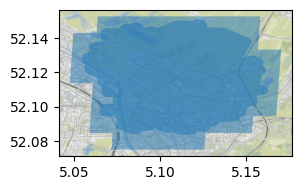

In [165]:
# Calculate overlapping rasters
i = 50
iso_buf = isochrones.iloc[i*6:i*6+1].isochrone_buf
reach_df = gdf[gdf.intersects(isochrones.iloc[i*6].isochrone_buf)]

# Show in small plot
ax = iso_buf.plot(alpha=0.5, figsize=(3,3))
reach_df.plot(ax=ax, alpha=0.5)
ctx.add_basemap(ax=ax, crs=isochrones.isochrone.crs, attribution="")

# Output
reach_df.head(2)

In [167]:
isochrones['tt_mnts_std'] = isochrones.tt_mnts.replace({10: 15, 25: 30})

In [168]:
reach = isochrones.pivot_table(index=['tt_mnts_std', 'pid'], columns='trmode', values='reach_pop')
reach = reach.reset_index().merge(isochrones[['pid', 'raster']].drop_duplicates(), on='pid').set_index(['tt_mnts_std', 'pid'])
reach = gpd.GeoDataFrame(reach).set_geometry('raster')
reach

,,cycling,driving_off,driving_peak,transit_bike_off,transit_bike_peak,transit_off,transit_peak,walking,raster
tt_mnts_std,pid,,,,,,,,,
15,0,60814.553575,1.176527e+05,1.116050e+05,82503.476555,82503.476555,38919.354019,38919.354019,12043.893265,"POLYGON ((5.03656 52.15263, 5.03587 52.14291, ..."
30,0,317555.291792,8.828875e+05,8.769889e+05,370903.456220,426499.358366,219005.812866,226095.182800,26653.140411,"POLYGON ((5.03656 52.15263, 5.03587 52.14291, ..."
15,1,66222.547821,1.159025e+05,9.575035e+04,66754.589516,66754.589516,18246.509399,21399.219604,12340.588989,"POLYGON ((5.00879 52.14291, 5.00810 52.13320, ..."
30,1,277388.253613,8.556245e+05,8.162051e+05,318585.369945,431709.782970,142885.740387,157263.067535,23713.342804,"POLYGON ((5.00879 52.14291, 5.00810 52.13320, ..."
15,10,143687.677973,2.764140e+05,2.613633e+05,158271.363413,158962.421274,67683.698151,67833.093811,26077.109772,"POLYGON ((5.08931 52.13320, 5.08861 52.12349, ..."
...,...,...,...,...,...,...,...,...,...,...
30,97,448740.928030,9.213197e+05,8.947682e+05,520872.294592,546143.999252,243076.709206,252282.167244,62031.998688,"POLYGON ((5.09653 52.04582, 5.09583 52.03611, ..."
15,98,115859.859482,2.406102e+05,2.250054e+05,125652.166367,126579.975815,7696.717316,7696.717316,9414.232574,"POLYGON ((5.11005 52.04582, 5.10935 52.03611, ..."
30,98,388398.014966,1.050146e+06,1.054874e+06,470060.542404,472680.586441,66145.703262,52940.783478,32211.758942,"POLYGON ((5.11005 52.04582, 5.10935 52.03611, ..."


In [169]:
reach.iloc[:, :-1].idxmax(axis='columns').value_counts()

driving_off          161
driving_peak          70
transit_bike_peak     11
transit_bike_off       3
cycling                3
Name: count, dtype: int64

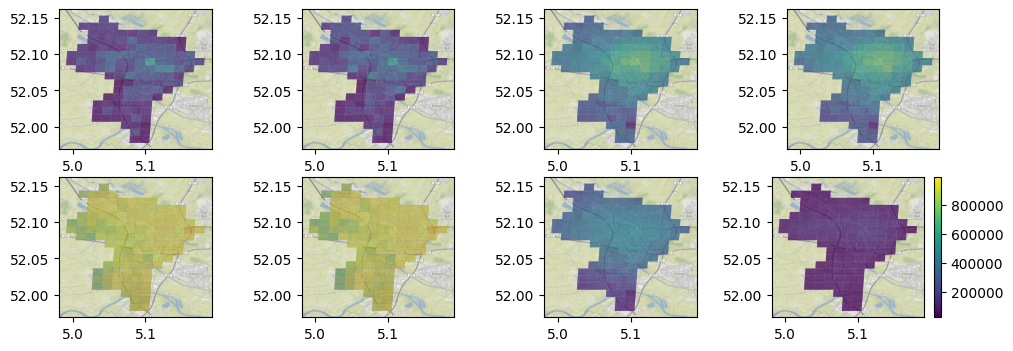

In [171]:
trmodes = isochrones.trmode.unique()
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 4))
for i, trmode in enumerate(isochrones.trmode.unique()):
    ax = axs[i//4, i%4]
    reach.plot(column=trmode, alpha=0.5, 
               vmin=isochrones.reach_pop.quantile(0.05), 
               vmax=isochrones.reach_pop.quantile(0.95), 
               legend=i==len(trmodes)-1, ax=ax)
    ctx.add_basemap(ax=ax, crs=reach.crs, attribution="")

,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,cell_pop,raster,reach_km2
68,3000-4-transit_bike_off-15m-g,4,POINT (15.41305 47.10014),transit_bike_off,15,2023-08-22 13:30:00+02:00,g,3000,"MULTIPOLYGON (((15.37661 47.10819, 15.37644 47...",True,2244.867676,"POLYGON ((1215000.000 5567000.000, 1215000.000...",1.571005e+07


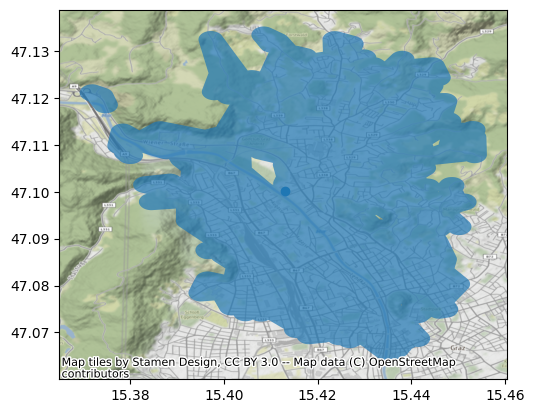

In [46]:
sample = isochrones[isochrones.trmode == 'transit_bike_off'].sample(1, random_state=19)
sample['isochrone'] = sample.isochrone.to_crs(sample.isochrone.estimate_utm_crs()).buffer(200).to_crs(sample.isochrone.crs)
ax = sample.set_geometry('isochrone').plot(alpha=0.7)
sample.set_geometry('startpt').plot(ax=ax)
ctx.add_basemap(ax=ax, crs=isochrones.isochrone.crs)
sample

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,cell_pop,raster,reach_km2
885,3000-55-transit_bike_off-30m-g,55,POINT (15.43916 47.03472),transit_bike_off,30,2023-08-22 13:30:00+02:00,g,3000,"POLYGON ((15.35811 47.00989, 15.35798 47.01004...",True,2905.198486,"POLYGON ((1218000.000 5560000.000, 1218000.000...",1.056492e+08


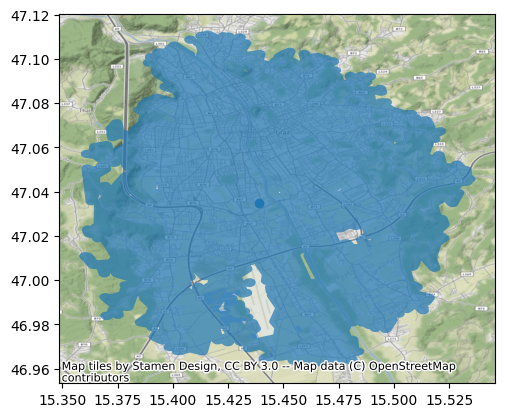

In [47]:
sample = isochrones[(isochrones.trmode == 'transit_bike_off') & (isochrones.pid == 55) & (isochrones.tt_mnts == 30)]
sample['isochrone'] = sample.isochrone.to_crs(sample.isochrone.estimate_utm_crs()).buffer(200).to_crs(sample.isochrone.crs)
ax = sample.set_geometry('isochrone').plot(alpha=0.7)
sample.set_geometry('startpt').plot(ax=ax)
ctx.add_basemap(ax=ax, crs=isochrones.isochrone.crs)
sample

In [48]:
# Define a dictionary to map categories to border colors
category_to_border_color = {
    'transit_off': '#264653',
    'transit_peak': '#363B44',
    'transit_bike_off': '#2A9D8F',
    'transit_bike_peak': '#51766D',
    'driving_off': '#E9C46A',
    'driving_peak': '#E9A569',
    'cycling': '#F4A261',
    'walking': '#E76F51',
}

/Users/ivo/opt/anaconda3/envs/DUTTv2/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,cell_pop,raster,reach_km2
801,3000-50-transit_off-30m-g,50,POINT (15.46620 47.04406),transit_off,30,2023-08-22 13:30:00+02:00,g,3000,"POLYGON ((15.43679 47.04522, 15.43668 47.04538...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",8.152141e+06
803,3000-50-transit_peak-30m-g,50,POINT (15.46620 47.04406),transit_peak,30,2023-08-22 08:30:00+02:00,g,3000,"MULTIPOLYGON (((15.43679 47.04522, 15.43668 47...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",8.152359e+06
805,3000-50-transit_bike_off-30m-g,50,POINT (15.46620 47.04406),transit_bike_off,30,2023-08-22 13:30:00+02:00,g,3000,"POLYGON ((15.36686 47.02965, 15.36667 47.02977...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",1.028865e+08
807,3000-50-transit_bike_peak-30m-g,50,POINT (15.46620 47.04406),transit_bike_peak,30,2023-08-22 08:30:00+02:00,g,3000,"POLYGON ((15.36686 47.02965, 15.36667 47.02977...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",1.028865e+08
809,3000-50-driving_off-25m-g,50,POINT (15.46620 47.04406),driving_off,25,2023-08-22 13:30:00+02:00,g,3000,"POLYGON ((15.22832 47.01016, 15.22826 47.01030...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",5.423381e+08
811,3000-50-driving_peak-25m-g,50,POINT (15.46620 47.04406),driving_peak,25,2023-08-22 08:30:00+02:00,g,3000,"POLYGON ((15.23236 47.01124, 15.23371 47.01351...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",5.245369e+08
813,3000-50-cycling-30m-g,50,POINT (15.46620 47.04406),cycling,30,2023-08-22 08:30:00+02:00,g,3000,"POLYGON ((15.37292 47.03311, 15.37290 47.03324...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",1.352353e+08
815,3000-50-walking-30m-g,50,POINT (15.46620 47.04406),walking,30,2023-08-22 08:30:00+02:00,g,3000,"POLYGON ((15.44649 47.03236, 15.44640 47.03233...",True,3993.333984,"POLYGON ((1220000.000 5561000.000, 1220000.000...",1.129305e+07


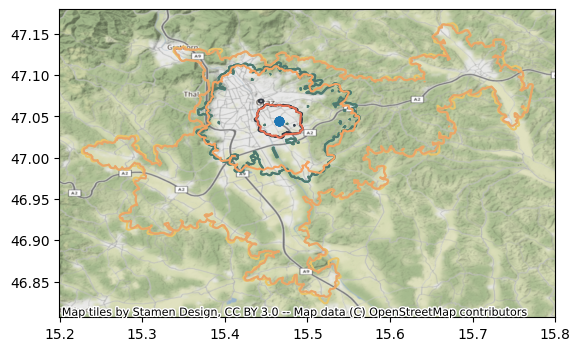

In [55]:
sample = isochrones[(isochrones.pid == 50) & (isochrones.tt_mnts >= 20)]
sample['isochrone'] = sample.isochrone.to_crs(sample.isochrone.estimate_utm_crs()).buffer(200).to_crs(sample.isochrone.crs)
border_colors = [category_to_border_color[category] for category in sample['trmode']]
ax = sample.set_geometry('isochrone').plot(facecolor='none', edgecolor=border_colors, linewidth=1.5,)
sample.set_geometry('startpt').plot(ax=ax)
ctx.add_basemap(ax=ax, crs=isochrones.isochrone.crs)
sample

<Axes: ylabel='Frequency'>

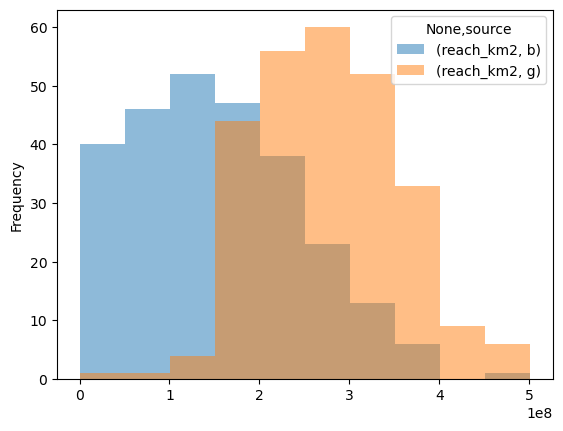

In [15]:
isochrones.source = isochrones.source.rename({'b': 'bing', 'g': 'graphhopper'})
comparison = isochrones.pivot_table(index='pid', columns='source', values=['reach_km2'])
comparison.plot.hist(alpha=0.5)

In [92]:
df = pd.read_pickle('../1-data/3-traveltime-cities/2167.isochrones.pcl')
gdf = gpd.GeoDataFrame(df)
gdf.head(3)

,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,cell_pop,raster,isochrone_buf,reach_km2,isochrone_buf
0,2167-0-transit_off-15m-g,0,POINT (4.78390 52.51746),transit_off,15,2023-08-22 13:30:00+02:00,g,2167,"MULTIPOLYGON (((4.77627 52.51939, 4.77912 52.5...",True,2276.701416,"POLYGON ((4.77743 52.52233, 4.77676 52.51259, ...","POLYGON ((4.77191 52.51896, 4.77186 52.51922, ...",7.430969e+05,"{'reach_n': 9, 'reach_km2': 9011631.412479594,..."
1,2167-0-transit_off-30m-g,0,POINT (4.78390 52.51746),transit_off,30,2023-08-22 13:30:00+02:00,g,2167,"MULTIPOLYGON (((4.77627 52.51939, 4.77912 52.5...",True,2276.701416,"POLYGON ((4.77743 52.52233, 4.77676 52.51259, ...","POLYGON ((4.77052 52.49594, 4.77026 52.49616, ...",2.214508e+06,"{'reach_n': 16, 'reach_km2': 16020692.36675075..."
2,2167-0-transit_peak-15m-g,0,POINT (4.78390 52.51746),transit_peak,15,2023-08-22 08:30:00+02:00,g,2167,"MULTIPOLYGON (((4.77627 52.51939, 4.77912 52.5...",True,2276.701416,"POLYGON ((4.77743 52.52233, 4.77676 52.51259, ...","POLYGON ((4.77191 52.51896, 4.77186 52.51922, ...",7.430969e+05,"{'reach_n': 9, 'reach_km2': 9011631.412479594,..."


In [90]:
gdf.isochrone_buf.iloc[:, 1].apply(pd.Series)

,reach_n,reach_km2,reach_pop,reach_geo
0,17,1.702263e+07,38919.354019,MULTIPOLYGON (((5.048010307803924 52.123486984...
1,78,7.810395e+07,219005.812866,"POLYGON ((4.992500659550002 52.10406470842798,..."
2,17,1.702263e+07,38919.354019,MULTIPOLYGON (((5.048010307803924 52.123486984...
3,80,8.010662e+07,226095.182800,"POLYGON ((4.992500659550002 52.10406470842798,..."
4,51,5.106792e+07,82503.476555,"POLYGON ((5.007409688706305 52.12348698419703,..."
...,...,...,...,...
1979,1087,1.088459e+09,953007.926283,"POLYGON ((4.870890433700287 51.91001247638324,..."
1980,46,4.606066e+07,26536.623410,"POLYGON ((5.037621287493276 51.9778955764823, ..."
1981,143,1.431880e+08,114811.223013,POLYGON ((5.020681712973047 51.929403793172966...
1982,9,9.011892e+06,9095.483429,"POLYGON ((5.078138348786788 51.9778955764823, ..."
